In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import torch
from torch.utils import data as torchdata
import glob
import os
import warnings
import itertools
#import altair as alt
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
#df_path = "/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n100_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path_sim = "/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n5500_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path = '/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv'

Failed to import duecredit due to No module named 'duecredit'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# PyMC 

## ADVI

In [2]:
#df_sim = pd.read_csv(df_path_sim)
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100, noise_source_path=df_path, noise_level=1)

In [9]:
model = sfp.monte_carlo.setup_model(df_sim)

In [10]:
with model:
    advi=pm.ADVI()
    advi_fit = advi.fit(10000, obj_optimizer=pm.adam(learning_rate=.01), )#more_replacements=map_tensor_batch,)# callbacks=[tracker])

Average Loss = -5,401.4: 100%|██████████| 10000/10000 [00:05<00:00, 1704.01it/s]
Finished [100%]: Average Loss = -5,401.4


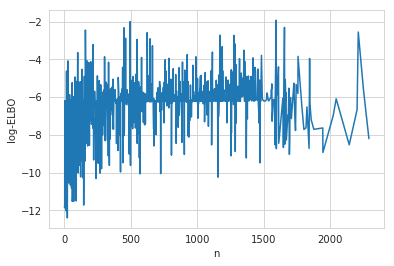

In [11]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [12]:
advi_trace = advi_fit.sample(500)

In [13]:
pm.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
voxel_norm,0.259179,0.004831,0.000194,0.249980,0.269167
sigma,0.995364,0.018782,0.000757,0.951151,1.026065
sf_ecc_slope,0.509445,0.008101,0.000373,0.492128,0.523162
sf_ecc_intercept,0.448265,0.028002,0.001332,0.394971,0.500991


/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


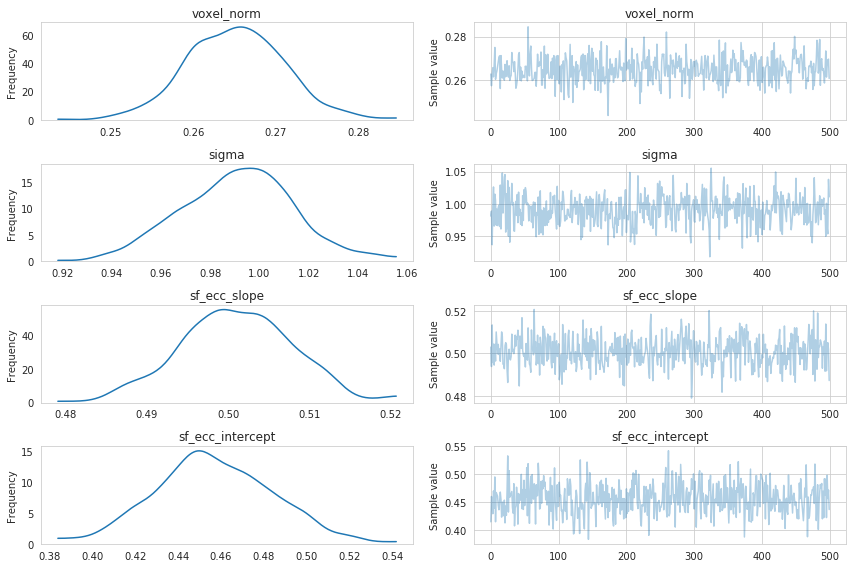

In [157]:
pm.traceplot(advi_trace);#, ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']);

## MCMC

In [48]:
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100, noise_source_path=df_path, noise_level=1)
df_sim.to_csv('test.csv')

In [74]:
inference_data = sfp.monte_carlo.main('test.csv', n_chains=8, n_samples=500,)

Started with 100 voxels, after filtering with df_filter string drop_voxels_with_negative_amplitudes have 0 voxels
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sf_ecc_intercept, sf_ecc_slope, sigma, voxel_norm]
Sampling 8 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3274.28draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 500/500 [00:00<00:00, 1152.64it/s]


In [83]:
inference_data = az.load_data('test2.nc')

In [84]:
az.summary(inference_data)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm,0.27,0.00,0.0,0.26,0.27,2502.0,1.00
sigma,1.00,0.02,0.0,0.97,1.02,2244.0,1.00
sf_ecc_slope,0.51,0.01,0.0,0.49,0.53,2095.0,1.01
sf_ecc_intercept,0.45,0.04,0.0,0.37,0.52,2245.0,1.01


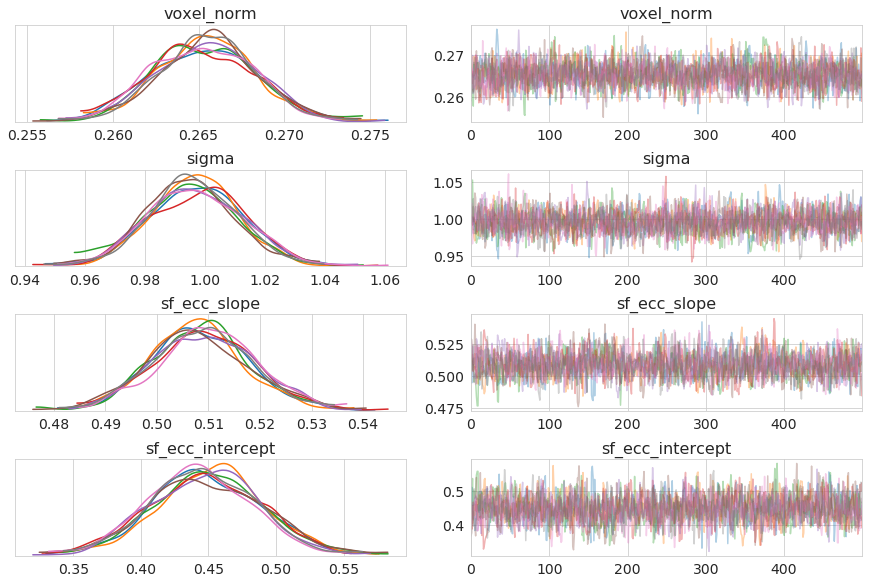

In [85]:
az.plot_trace(inference_data);

# Actual results

## First attempt

It worked with the `advi+adapt_diag` initialization, but not with `adapt_diag` or `jitter+adapt_diag`

In [72]:
inference_data_1 = az.load_data('/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial/sub-wlsubj001/ses-01/sub-wlsubj001_ses-01_task-sfp_v1_e1-12_summary_s500_c8_i-advi+adapt_diag_ntarget_accept=.9_mcmc.nc')
inference_data_2 = az.load_data('/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/mcmc/stim_class/posterior/initial/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary_s500_c8_i-advi+adapt_diag_ntarget_accept=.9_mcmc.nc')

In [74]:
az.summary(inference_data_1)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm,0.16,0.0,0.0,0.16,0.16,2319.0,1.0
sigma,2.37,0.0,0.0,2.37,2.38,2285.0,1.0
sf_ecc_slope,0.13,0.0,0.0,0.12,0.13,1795.0,1.0
sf_ecc_intercept,0.36,0.0,0.0,0.35,0.36,1899.0,1.0


In [75]:
az.summary(inference_data_2)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
voxel_norm,0.17,0.0,0.0,0.17,0.17,2944.0,1.0
sigma,1.93,0.0,0.0,1.93,1.93,2123.0,1.0
sf_ecc_slope,0.14,0.0,0.0,0.14,0.14,1916.0,1.0
sf_ecc_intercept,0.19,0.0,0.0,0.19,0.19,1941.0,1.0


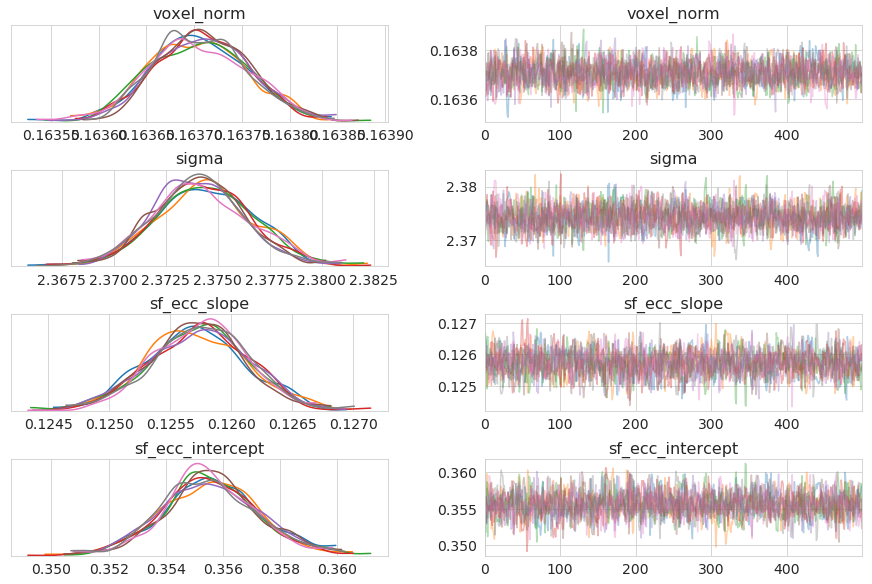

In [76]:
az.plot_trace(inference_data_1);

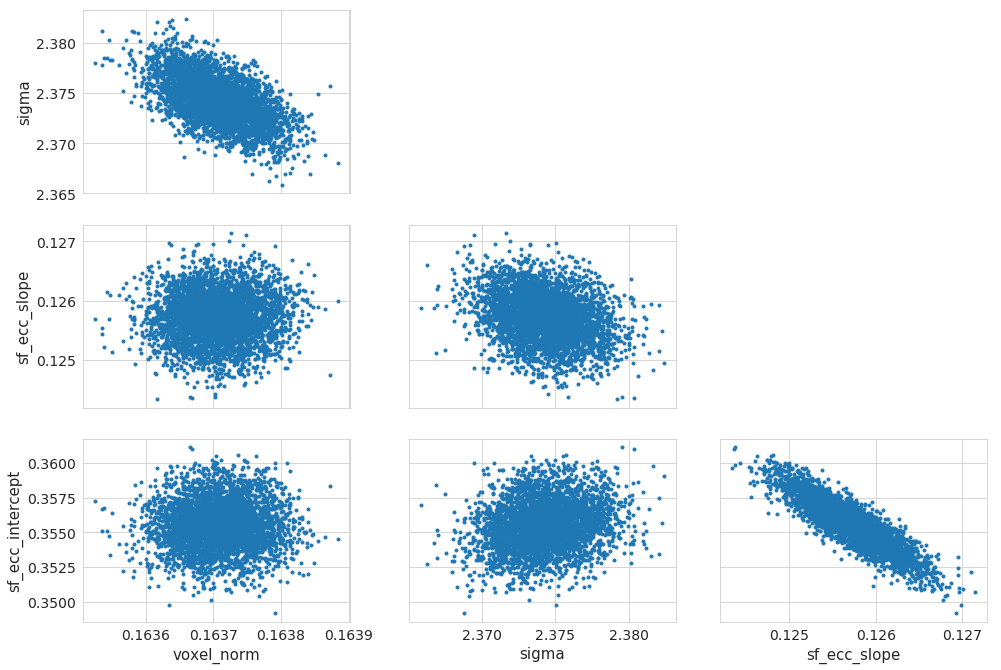

In [77]:
az.plot_pair(inference_data_1);

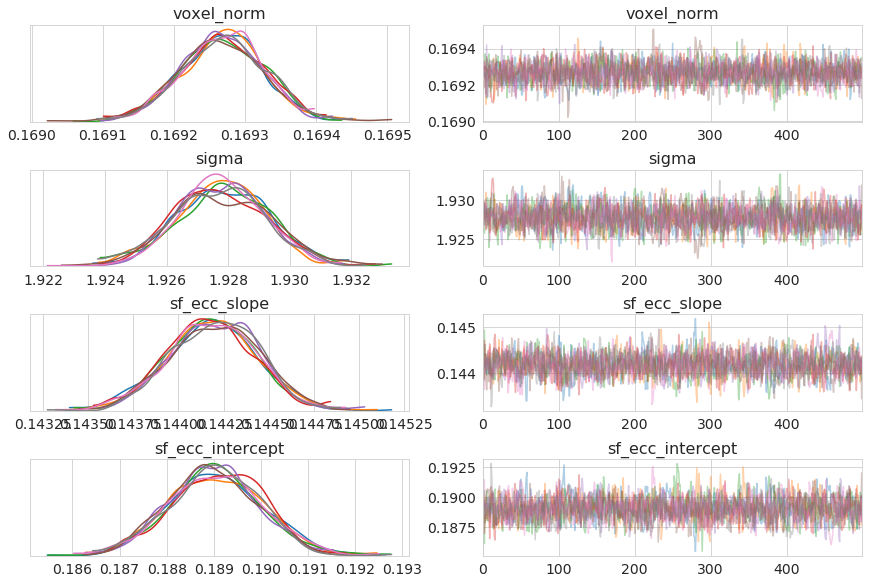

In [78]:
az.plot_trace(inference_data_2);

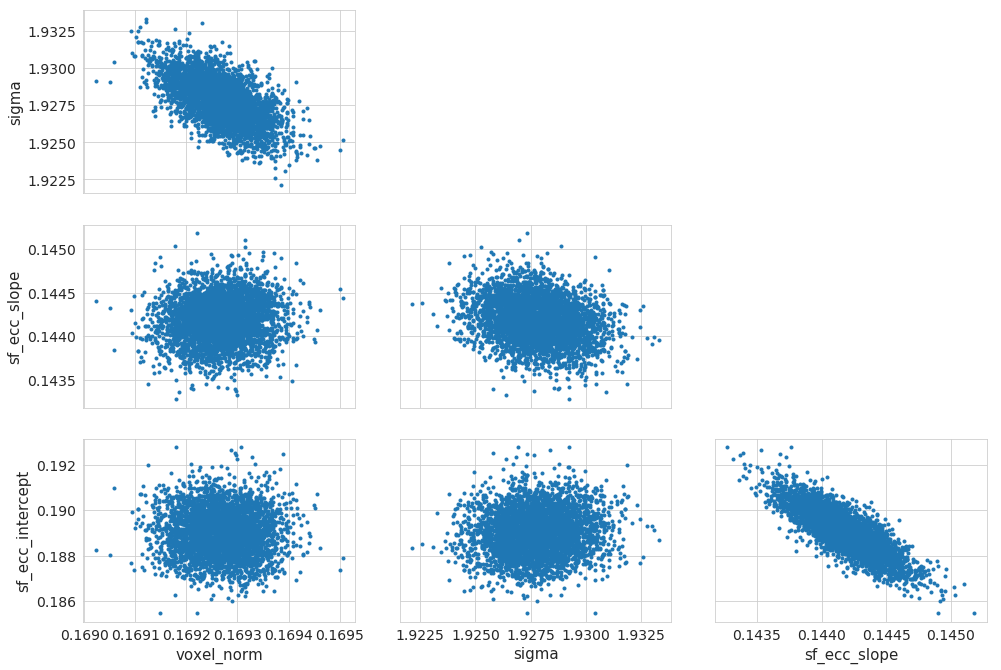

In [79]:
az.plot_pair(inference_data_2);

## Investigating what's going on

In [83]:
#df = pd.read_csv('/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv')
df = pd.read_csv('/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj001/ses-01/sub-wlsubj001_ses-01_task-sfp_v1_e1-12_summary.csv')

In [84]:
df_filter = sfp.model.construct_df_filter('drop_voxels_with_negative_amplitudes,drop_voxels_near_border')

In [85]:
df.voxel.nunique()

4414

In [86]:
df = df_filter(df)

In [87]:
df.voxel.nunique()

3531

In [69]:
all_voxels = df.voxel.unique()
np.random.shuffle(all_voxels)
np.random.seed(2)
splits = np.array_split(all_voxels, 5)
good_starts = []

In [105]:
model = sfp.monte_carlo.setup_model(df)
with model:
    trace = pm.sample(500, chains=8, cores=8, tune=1500, init='advi+adapt_diag', nuts_kwargs={'target_accept': .9})

Started with 3531 voxels, after filtering with df_filter_string None have 3531 voxels
INFO (theano.gof.compilelock): Refreshing lock /e/3.2/p1/broderick/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.2.1511-Core-x86_64-3.6.3-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = -3.9088e+05:  25%|██▍       | 49816/200000 [21:15<1:01:54, 40.44it/s]
Interrupted at 49,818 [24%]: Average Loss = 1.0946e+07
INFO (theano.gof.compilelock): Refreshing lock /e/3.2/p1/broderick/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.2.1511-Core-x86_64-3.6.3-64/lock_dir/lock
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [rel_amplitude_obliques, rel_amplitude_cardinals, abs_amplitude_obliques, abs_amplitude_cardinals, rel_mode_obliques, rel_mode_cardinals, abs_mode_obliques, abs_mode_cardinals, sf_ecc_intercept, sf_ecc_slope, sigma, voxel_norm]
Sampling 8 chains: 100%|██████████| 16000/16000 [16:59<00:00,  1.68draws/s]


In [106]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
voxel_norm,0.164248,0.000049,7.681568e-07,0.164154,0.164345,4679.482927,0.999735
abs_mode_cardinals,-0.005347,0.001173,1.599525e-05,-0.007644,-0.003052,5836.305892,1.000595
abs_mode_obliques,-0.017426,0.001170,1.574436e-05,-0.019739,-0.015128,5287.592962,0.999153
rel_mode_cardinals,0.226700,0.001373,2.017641e-05,0.224013,0.229399,4852.253689,0.999566
rel_mode_obliques,0.084836,0.000903,1.179157e-05,0.083088,0.086641,5408.293807,1.000029
abs_amplitude_cardinals,0.028976,0.000347,4.855907e-06,0.028306,0.029650,5023.827478,0.999235
abs_amplitude_obliques,-0.017720,0.000338,5.084655e-06,-0.018347,-0.017025,5259.886879,0.999907
rel_amplitude_cardinals,-0.022810,0.000348,4.829295e-06,-0.023472,-0.022138,5066.523429,1.000396
rel_amplitude_obliques,0.029612,0.000266,4.400600e-06,0.029097,0.030153,4521.964734,0.999926
sigma,2.363616,0.002247,3.524728e-05,2.359106,2.367971,4264.104810,0.999616


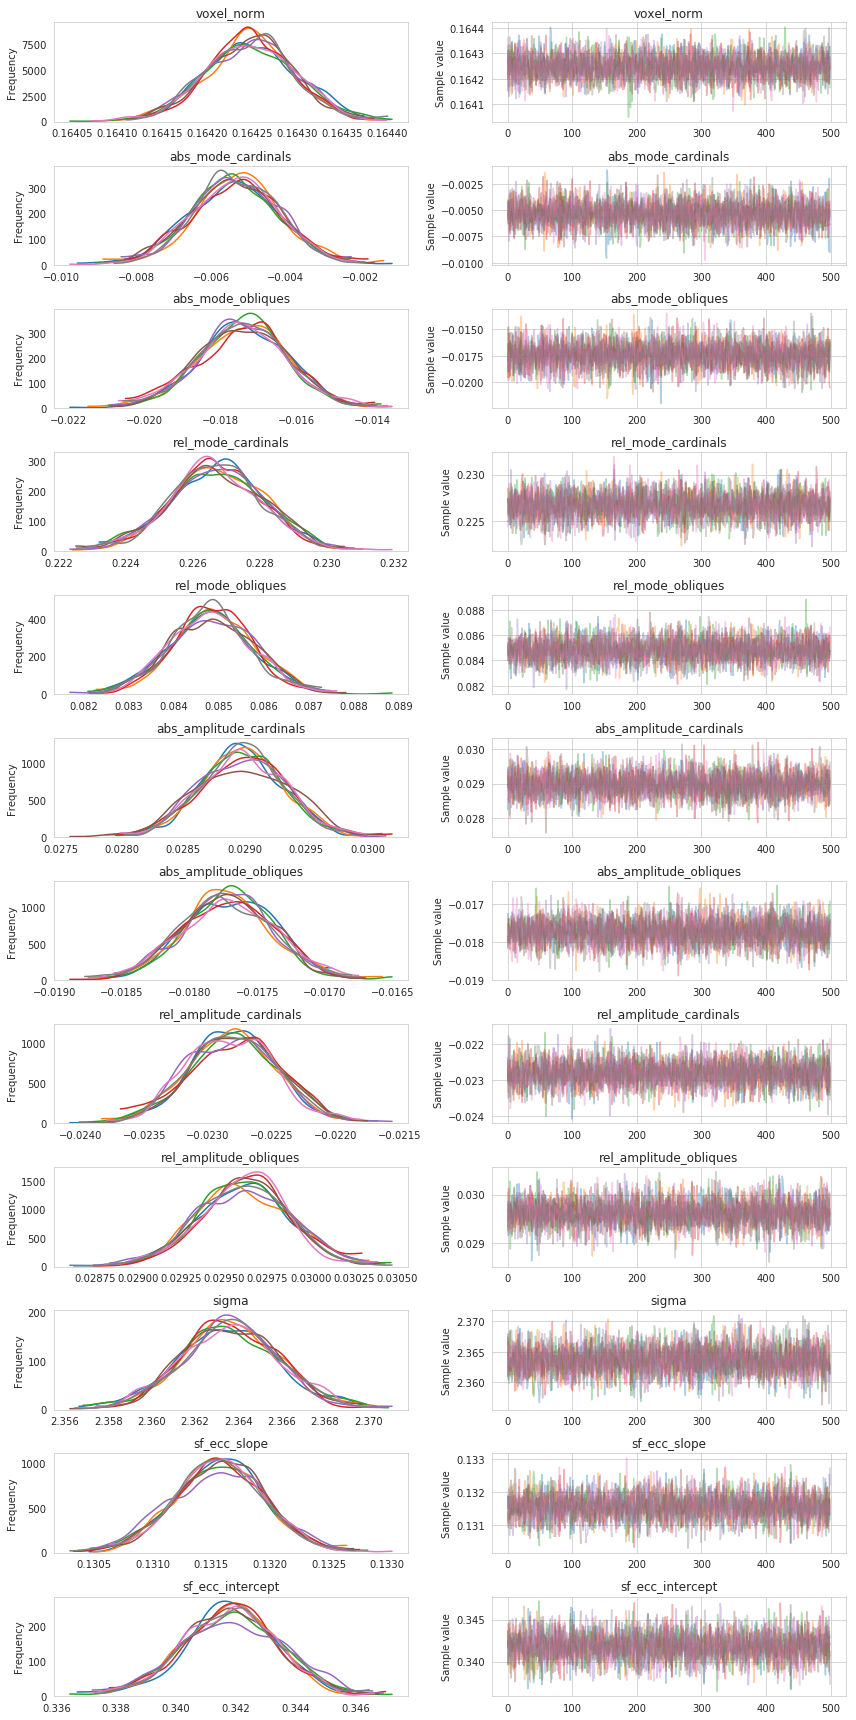

In [107]:
pm.traceplot(trace);

In [359]:
data= az.from_pymc3(trace)

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/arviz/data/base.py:123: SyntaxWarning: More chains (8) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,
/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


In [360]:
data.posterior.isel(draw=0).to_dataframe()

,draw,voxel_norm,sigma,sf_ecc_slope,sf_ecc_intercept
chain,,,,,
0,0,1.0,2.0,1.0,1.0
1,0,1.0,2.0,1.0,1.0
2,0,1.0,2.0,1.0,1.0
3,0,1.0,2.0,1.0,1.0
4,0,1.0,2.0,1.0,1.0
5,0,1.0,2.0,1.0,1.0
6,0,1.0,2.0,1.0,1.0
7,0,1.0,2.0,1.0,1.0
